In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/scratch/anissa.el/macro_micro_niches/macro_micro_niches2022/TMENS_analysis/notebooks/keren_building_blocks_analysis'

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from src.CellAbundance import CellAbundance, join_abundance_matrices, generate_abundance_matrix
from src.utils.archetypes import ArchetypalAnalysis
from src.utils.visualization import plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper

### 3D Archetypes - All tumors - 4 archetypes

In [3]:
CELL_TYPES = ['CD8-T', 'Other immune', 'DC / Mono', 'CD3-T', 'B', 'NK', 'Keratin-positive tumor', 'Tumor', 
              'CD4-T', 'Mesenchymal-like', 'Macrophages', 'Endothelial', 'Tregs', 'Unidentified', 'DC', 'Mono / Neu', 
              'Neutrophils']
patient_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
N_SITE = 100
RADIUS = 25
ROOT_DATA_PATH = "../../data/cell_positions_data"#"/srv/mfs/hausserlab/fabio/output/cell_positions_data" #"../../../../fabio/output/cell_positions_data"
METHOD = "gaussian"

gauss_ca_list = generate_abundance_matrix(CELL_TYPES, patient_ids, N_SITE, RADIUS, method=METHOD, snr=3,center_sites_cells=False,root=ROOT_DATA_PATH)
sites, patients_ids,sites_ids, _ = join_abundance_matrices(gauss_ca_list)

pca_3d = PCA()
pc3d = pca_3d.fit_transform(sites)

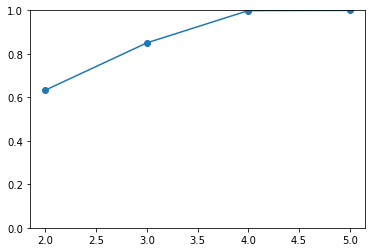

In [4]:
n_archs = list(range(2, 6))

lst_exp_var = []
for n_arch in n_archs:
    AA = ArchetypalAnalysis(n_archetypes = n_arch, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                            
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
    AA.fit(pc3d[:, :3])
    lst_exp_var.append(AA.explained_variance_)

plt.plot(n_archs, lst_exp_var, '-o')
plt.ylim(0, 1)
plt.show()

In [4]:
AA_3D = ArchetypalAnalysis(n_archetypes = 4, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
AA_3D.fit_transform(pc3d[:, :3])

array([[ 3.47124555e-04, -3.06962300e-04, -5.17320418e-04],
       [ 1.06548009e-03, -1.82692135e-05, -2.64183244e-04],
       [-1.82612128e-04,  1.39445834e-04, -3.79957484e-04],
       ...,
       [-3.42464199e-03, -1.34219164e-03, -8.09685239e-04],
       [-1.51776535e-03, -7.56257337e-05, -2.31632840e-04],
       [-3.31275284e-03, -1.15412719e-03, -9.44135594e-04]])

In [5]:
AA_3D.alfa.T.shape

(4000, 4)

## Analysis predicted versus observed cell abundance

In [ ]:
## COMPUTE RESIDUALS FROM ARCHETYPAL ANALYSIS
import scipy.linalg as scla
ncomp = 3

#residuals_AA3D = (AA_3D.X- AA_3D.X_approx).T
X_fitted = np.dot(AA_3D.X_approx.T, pca_3d.components_[:ncomp,:])+np.mean(sites, axis=0)
sum_xfit = np.sum(X_fitted,axis=1)
mins_xfit = -np.amin(X_fitted,axis=1)

#print(sum_xfit)
#print(np.sum((X_fitted/X_fitted.sum(axis=1)[:,None])*100,axis=1))
#((X_fitted+mins_xfit[:,None])/sum_xfit[:,None])*100
X_fit_cells = pd.DataFrame(X_fitted, columns = CELL_TYPES )#(((X_fitted+mins_xfit[:,None])/sum_xfit[:,None])*100, columns = CELL_TYPES)
sites_cells = pd.DataFrame(sites, columns = CELL_TYPES )
#sums_sites=np.sum(sites,axis=1)
#mins_sites = -np.amin(sites,axis=1)
#sites_cells = pd.DataFrame(((sites+mins_sites[:,None])/sums_sites[:,None]*100),columns = CELL_TYPES)#np.log(((sites+mins_sites[:,None])/sums_sites[:,None]*100)+1)
print(CELL_TYPES)
#ct = "Keratin-positive tumor"
#ct = "B"
#ct = "CD8-T"
#ct = "CD4-T"
#ct = "Macrophages"
#ct = "Mesenchymal-like"
#fig, axs = plt.subplots(4, 5, subplot_kw=dict(projection="polar"))
#axs[0, 0].plot(x, y)
#axs[1, 1].scatter(x, y)
for ct in CELL_TYPES:
    plt.scatter(x= sites_cells[ct],y = X_fit_cells[ct])
    plt.xlabel("observed "+ct)
    plt.ylabel("predicted "+ct)
    plt.show()

'''
plt.scatter(x= sites_cells[ct],y = X_fit_cells[ct] - sites_cells[ct])
plt.show()

print(np.amin(AA_3D.alfa))

offset=1e-5
plt.scatter(x= (sites_cells["CD4-T"]+offset),y = (sites_cells["CD8-T"]+offset))
plt.show()
plt.scatter(x= np.log10(sites_cells["CD4-T"]+offset),y = np.log10(sites_cells["CD8-T"]+offset))
#plt.scatter(x= np.log10(sites_cells["Keratin-positive tumor"]+offset),y = np.log10(sites_cells["CD8-T"]+offset))
plt.show()

#residuals_AA3D = np.dot((AA_3D.X- AA_3D.X_approx).T, pca_3d.components_[:ncomp,:])+np.mean(sites, axis=0)
#residual_cells = pd.DataFrame(residuals_AA3D, columns = CELL_TYPES)
#print(X_fit_cells["CD4-T"])
#plt.scatter(x = X_fit_cells["CD4-T"],y=residual_cells["CD4-T"])
#plt.show()
#print(((sites/sites.sum(axis=1)[:,None])*100)+1,axis=1)
'''



In [ ]:
ncomp = 3

## GET log transformed of cell % for each site 
sums_sites=np.sum(sites,axis=1)
mins_sites = -np.amin(sites,axis=1)
sites_cells = pd.DataFrame(np.log(((sites+mins_sites[:,None])/sums_sites[:,None]*100)+1),columns = CELL_TYPES)#np.log(((sites+mins_sites[:,None])/sums_sites[:,None]*100)+1)
#sites

## ADD TMENs
BBs = np.dot(AA_3D.archetypes.T, pca_3d.components_[:ncomp,:])+np.mean(sites, axis=0)
#print(BBs)
sums_BBs = BBs.sum(axis = 1)
mins_BBs = -np.amin(BBs,axis = 1)
#print(mins_BBs)
TMENs = pd.DataFrame(np.log(((BBs+mins_BBs[:,None])/sums_BBs[:,None]*100)+1),columns = CELL_TYPES)#np.log(((BBs+mins_BBs[:,None])/sums_BBs[:,None]*100)+1)
#print(TMENs) BBs
#print(np.log(BBs+1))
#print(BBs)

## PLOT LOG(%) of cells + TMENs
plt.scatter(x = sites_cells["CD4-T"],y = sites_cells["CD8-T"])
plt.scatter(x = TMENs["CD4-T"],y = TMENs["CD8-T"],color="red")
names_tmens = ["TLS", "Inflamm","cancer","fibrotic"]
for i, txt in enumerate(names_tmens):
    plt.annotate(txt, (TMENs["CD4-T"][i], TMENs["CD8-T"][i]))
plt.xlabel("log(%CD4 T cells)")
plt.ylabel("log(%CD8 T cells)")
plt.show()

In [ ]:
fig, axs = plt.subplots(len(CELL_TYPES), len(CELL_TYPES))

for i in CELL_TYPES:
    for j in CELL_TYPES:

        idx1 = CELL_TYPES.index(i)
        idx2 = CELL_TYPES.index(j)
        axs[idx1,idx2].scatter(x = sites_cells[i],y = sites_cells[j])
        axs[idx1,idx2].scatter(x = TMENs[i],y = TMENs[j],color="red")
        names_tmens = ["TLS", "Inflamm","cancer","fibrotic"]
        for k, txt in enumerate(names_tmens):
            axs[idx1,idx2].annotate(txt, (TMENs[i][k], TMENs[j][k]))
        axs[idx1,idx2].set_xlabel("log(% "+i+" cells)")
        axs[idx1,idx2].set_ylabel("log(% "+j+" cells)")
fig.show()    

### Visualization  and interpretation of archetypes

In [14]:
def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array([[255, 0, 223],[255,0,0],[70,203,236],[0,0,0]]).T #np.array([[255, 0, 0], [0, 153, 51], [0, 0, 255], [255, 255, 0]]).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA_3D.alfa.T]
p = np.array(sites_archetype)
p[p > 1]

array([], dtype=float64)

<IPython.core.display.Javascript object>


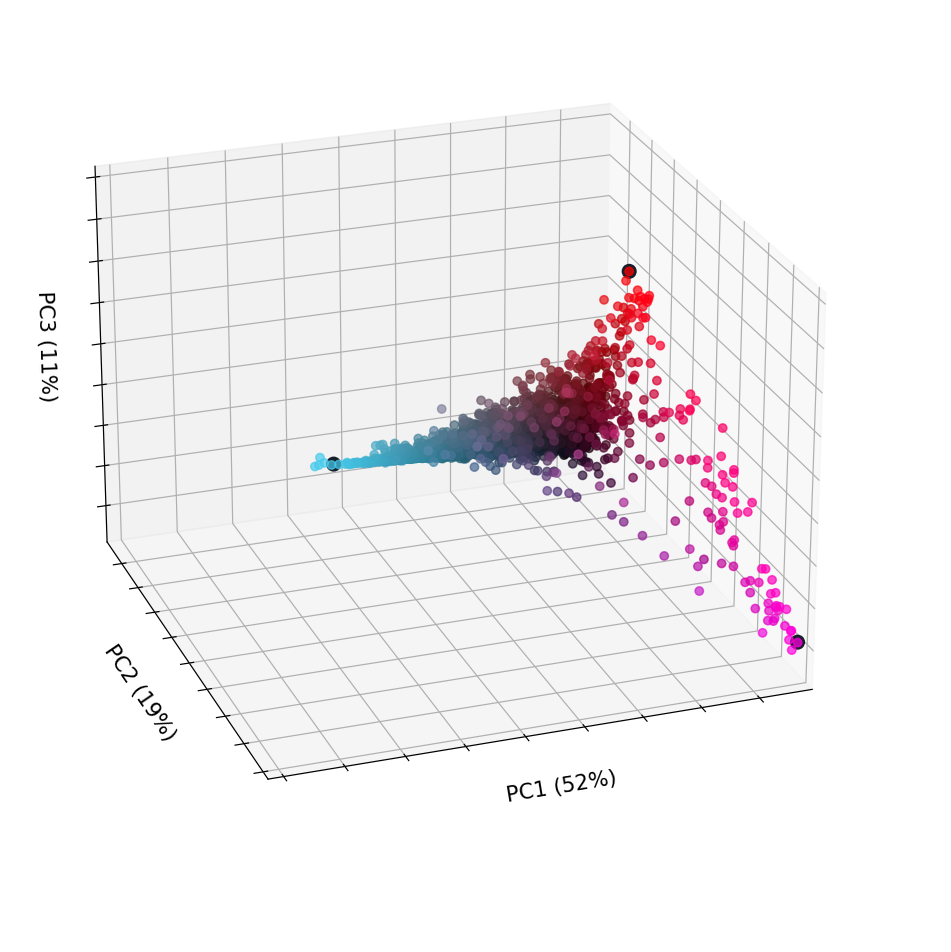

In [18]:
%matplotlib notebook
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
font = {'size'   : 14}
matplotlib.rc('font', **font)
pc3d[:, 4]= patients_ids
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=(0, 0, 1, 1), elev=21, azim=-58)

minimum = np.amin(pc3d[:, 0:3])#, maximum = _calculate_pca_max_min(principal_components[:, 0:3])
maximum = np.amax(pc3d[:, 0:3])
evr = pca_3d.explained_variance_ratio_

#col= np.where(pc3d[:, 4] ==17,"b",(0.1, 0.2, 0.5, 0.05))
ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.7,c=p,s=30)#,alpha=al,markerfacecolor="None",markeredgecolor="blue"
ax.scatter(AA_3D.archetypes[0, :],AA_3D.archetypes[1, :],AA_3D.archetypes[2, :],c="#17202A",alpha=1,s=80)

### Axes settings
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)   
ax.set_xlabel("PC1 ({}%)".format(int(round(evr[0] * 100)))) #("PC1 ({:.2f}% Exp. Var.)".format(evr[0] * 100))
ax.set_ylabel("PC2 ({}%)".format(int(round(evr[1] * 100)))) #("PC2 ({:.2f}% Exp. Var.)".format(evr[1] * 100))
ax.set_zlabel("PC3 ({}%)".format(int(round(evr[2] * 100)))) #("PC3 ({:.2f}% Exp. Var.)".format(evr[2] * 100))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

<IPython.core.display.Javascript object>


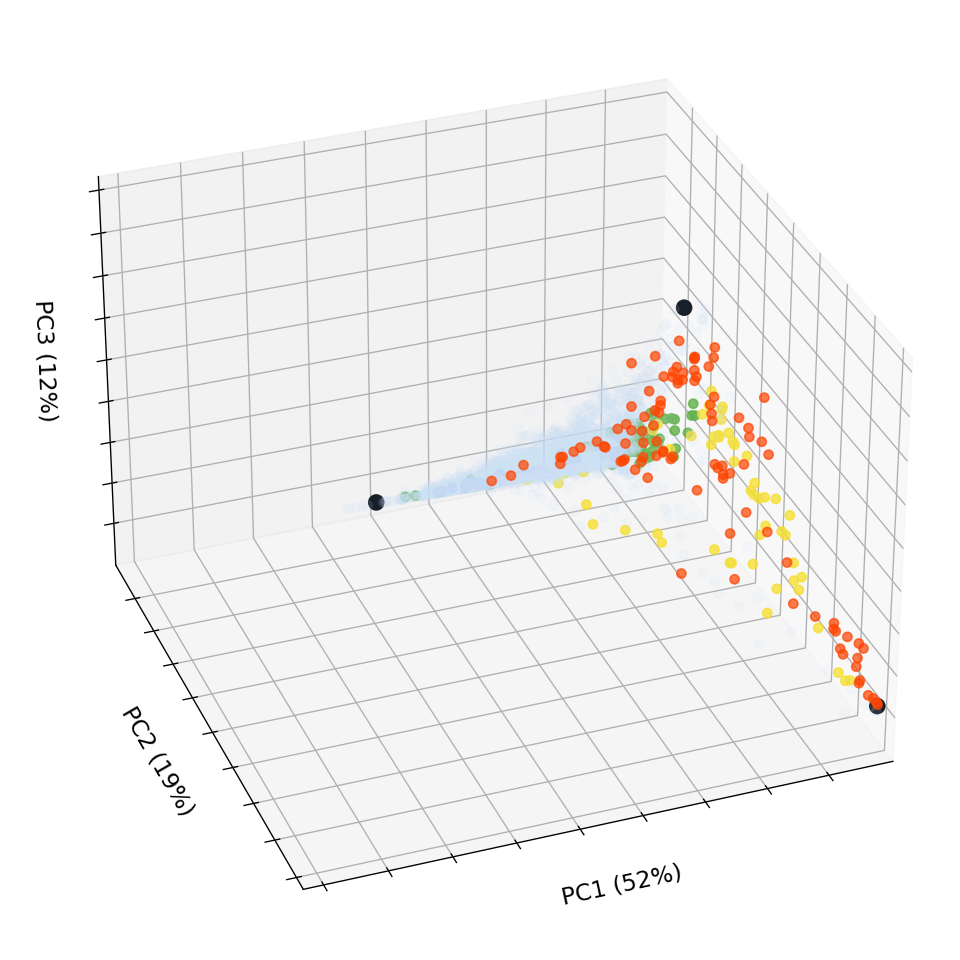

In [31]:
%matplotlib notebook
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
font = {'size'   : 14}
matplotlib.rc('font', **font)
pc3d[:, 4]= patients_ids
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=(0, 0, 1, 1), elev=21, azim=-58)

minimum = np.amin(pc3d[:, 0:3])#, maximum = _calculate_pca_max_min(principal_components[:, 0:3])
maximum = np.amax(pc3d[:, 0:3])
evr = pca_3d.explained_variance_ratio_
#FIXME add groups of sites(per patient) by layer, other patients being first plotted
#colors = patients_ids[]#189200 
## COlor 3 patients 
# red: #FF4500 patient35
# green: #41A317 patent 4
# gold yellow: #FFDF00 28
# light transparent blue: #B0CFDE1A ## 3,40,39

#col = np.where(pc3d[:, 4] ==5,"#FF4500",np.where(pc3d[:, 4] ==15,"#41A317",np.where(pc3d[:, 4] ==17,"#FFDF00","#B0CFDE1A")))#np.where(x<1,'k',np.where(y<5,'b','r'))

col = np.where(pc3d[:, 4] ==35,"#FF4500",np.where(pc3d[:, 4] ==4,"#41A317",np.where(pc3d[:, 4] ==28,"#FFDF00","#cce2fc")))#np.where(x<1,'k',np.where(y<5,'b','r'))

#col= np.where(pc3d[:, 4] ==17,"b",(0.1, 0.2, 0.5, 0.05))
patients_cols = {28:"#FFDF00",35:"#FF4500",4:"#41A317"}
col = "#cce2fc"
ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.1,facecolors=col,s=30)
for p in patients_cols.keys():
    pc3d_patient=pc3d[pc3d[:, 4]==p]
    ax.scatter(pc3d_patient[:, 0],pc3d_patient[:, 1],pc3d_patient[:, 2],alpha=0.7,c=patients_cols[p],s=30)
    
    
#col2 = np.where(pc3d[:, 4] ==35,"#FF4500",np.where(pc3d[:, 4] ==4,"#41A317",np.where(pc3d[:, 4] ==28,"#FFDF00",)))
#ax.scatter(pc3d[:, 0],pc3d[:, 1],pc3d[:, 2],alpha=0.7,c=col2,s=30)#,alpha=al,markerfacecolor="None",markeredgecolor="blue"
ax.scatter(AA_3D.archetypes[0, :],AA_3D.archetypes[1, :],AA_3D.archetypes[2, :],c="#17202A",alpha=1,s=80)

### Axes settings
ax.set_xlim(minimum, maximum)
ax.set_ylim(minimum, maximum)
ax.set_zlim(minimum, maximum)
ax.set_xlabel("PC1 ({}%)".format(int(round(evr[0] * 100))))
ax.set_ylabel("PC2 ({}%)".format(int(round(evr[1] * 100))))
ax.set_zlabel("PC3 ({}%)".format(int(round(evr[2] * 100))))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

In [ ]:
%matplotlib notebook
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
plt=plot_3Dscatter_pca(pc3d, pca_3d.explained_variance_ratio_, labels=sites_archetype, archetypes=AA_3D.archetypes);
#plt.savefig("/srv/mfs/hausserlab/anissa.el/figs/plot_pca_gaussian25.svg")

In [ ]:
un, counts = np.unique(np.argmax(AA_3D.alfa.T, axis=1), return_counts=True)
bb_counts = dict(zip(un+1, (counts/4000)*100))
bb_counts

In [ ]:
AA_3D.plot_simplex(AA_3D.alfa, plot_args={'c': sites_archetype})

In [9]:
n_comp = 3
res = np.dot(AA_3D.archetypes.T, pca_3d.components_[:n_comp,:])+np.mean(sites, axis=0)
print(res.shape)
#pd.DataFrame(res).to_csv("/srv/mfs/hausserlab/anissa.el/ImmuneStates/wagner_analysis/data/archetypes_building_blocks_17cells_space.csv")

(4, 17)


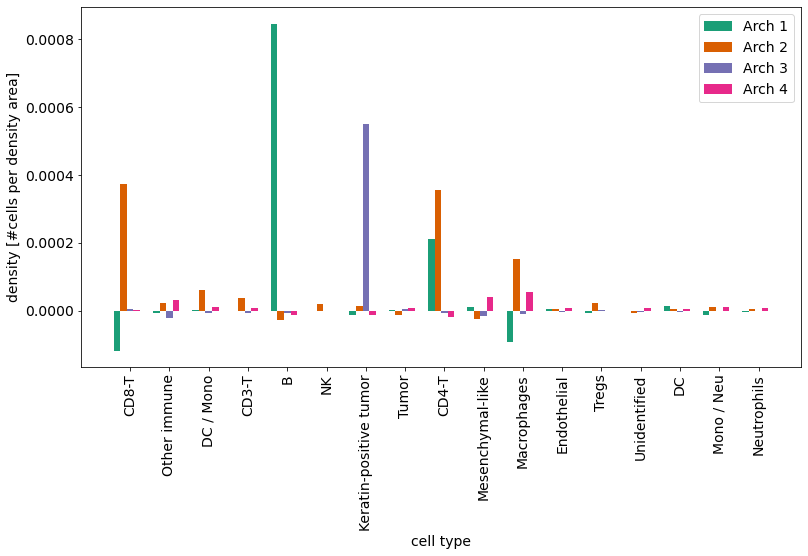

In [27]:
#FIXME negative values for density !!!
RADIUS = 25
archetype_colors = [[255/255, 0., 223/255],[255/255,0.,0.],[70/255,203/255,236/255],[0.,0.,0.]]#[[1., 0., 0.], [0. , 0.6, 0.2], [0., 0., 1.], [1.0, 1.0, 0.]]
archetypes_bar_plot(res, CELL_TYPES,None, y_axis = 'density', radius = RADIUS,path_fig="/scratch/anissa.el/figs/fig2/test.svg");#(res, CELL_TYPES, archetype_colors, y_axis = 'density', radius = RADIUS,path_fig="/scratch/anissa.el/figs/fig2/test.svg")#"/scratch/anissa.el/figs/fig2/barplotTMENS.svg"

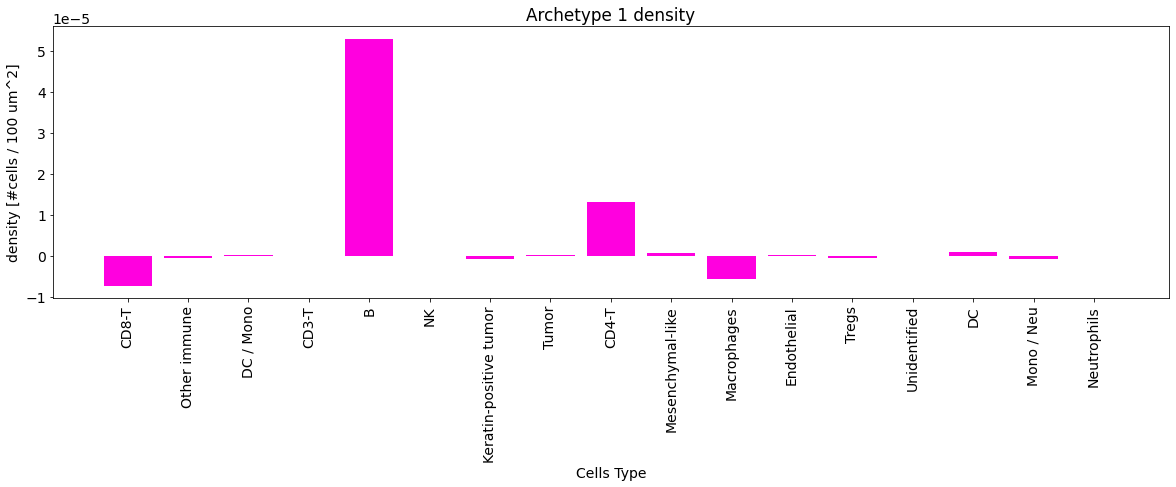

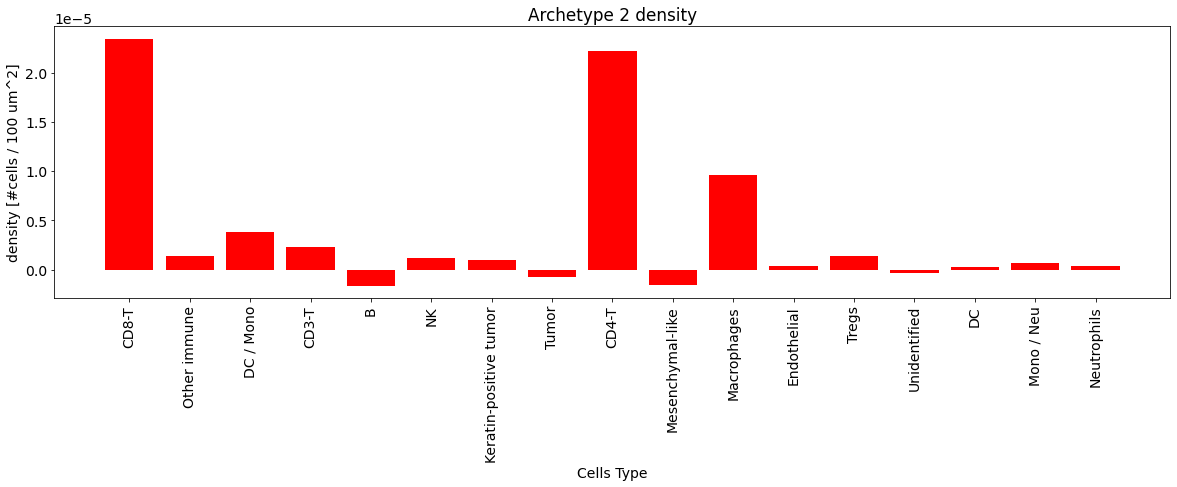

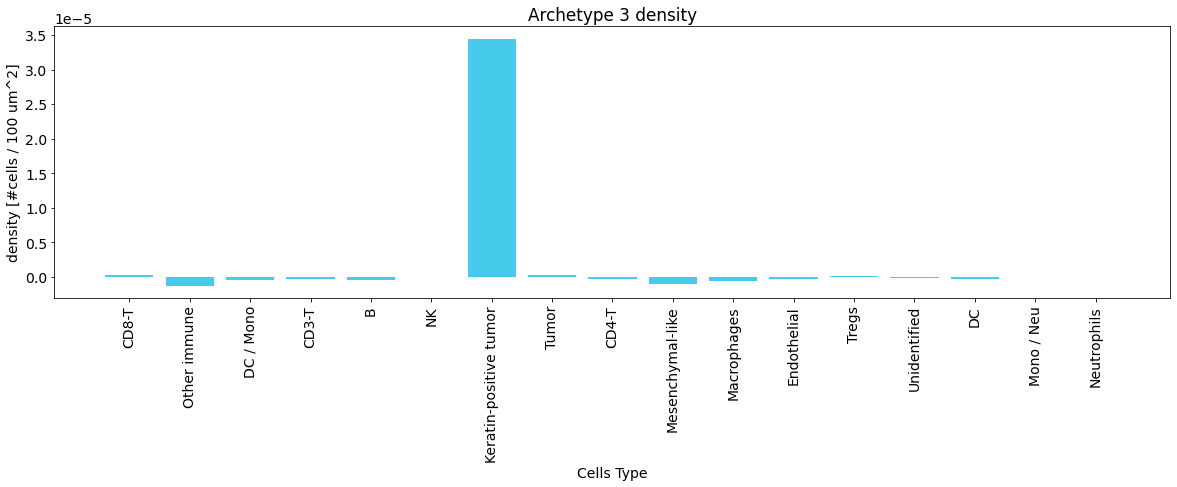

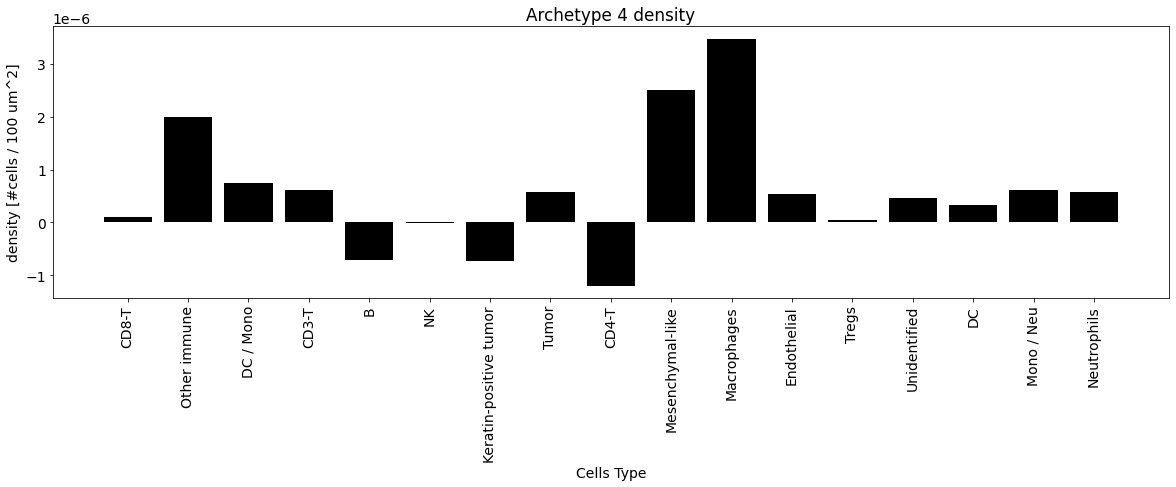

In [23]:
for a in range(4):
    archetype_simple_plot(res[a], a, archetype_colors, CELL_TYPES, y_axis='density')

In [ ]:
d = np.array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1)
print(d)
new_pc = pca_3d.transform(d)
AA_3D.transform(new_pc[:, :3])

### Export data from PCA and Archetype analysis

In [ ]:
import pickle
with open("../../output/pca_3d_gaussian", "wb") as f:
    pickle.dump(pca_3d, f)

with open("../../output/AA_3D_gaussian", "wb") as f:
    pickle.dump(AA_3D, f)

### 3D Archetypes - All tumors - 5 archetypes

In [4]:
CELL_TYPES = ['CD8-T', 'Other immune', 'DC / Mono', 'CD3-T', 'B', 'NK', 'Keratin-positive tumor', 'Tumor', 
              'CD4-T', 'Mesenchymal-like', 'Macrophages', 'Endothelial', 'Tregs', 'Unidentified', 'DC', 'Mono / Neu', 
              'Neutrophils']
#patient_ids = [1, 2, 3, 4, 5]
patient_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
N_SITE = 100
RADIUS = 100
ROOT_DATA_PATH = "../../data/cell_positions_data"

abs_log_ca_list = generate_abundance_matrix(CELL_TYPES, patient_ids, N_SITE, RADIUS, method='abs', snr=3, root=ROOT_DATA_PATH)
sites, patients_ids,s_ids, _ = join_abundance_matrices(abs_log_ca_list)
pca_3d = PCA()
pc3d = pca_3d.fit_transform(sites)

In [ ]:
plt.plot(n_archs, lst_exp_var, '-o')
plt.ylim(0, 1)
plt.show()

In [ ]:
n_archetypes = 5

In [ ]:
AA_3D = ArchetypalAnalysis(n_archetypes = n_archetypes, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
AA_3D.fit_transform(pc3d[:, :3])

In [ ]:
np.array([0, 153, 51]) / 255

In [ ]:
def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array([[255, 0, 0], [0, 153, 51], [0, 0, 255], [255, 255, 0], [255, 0, 255]]).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA_3D.alfa.T]
p = np.array(sites_archetype)
p[p > 1]

In [ ]:
#%matplotlib notebook
plot_3Dscatter_pca(pc3d, pca_3d.explained_variance_ratio_, labels=sites_archetype, archetypes=AA_3D.archetypes)

In [ ]:
pc3d[:, :3]
AA_3D.alfa.T

In [ ]:
AA_3D.plot_simplex(AA_3D.alfa, plot_args={'c': sites_archetype})

In [ ]:
n_comp = 3
res = np.dot(AA_3D.archetypes.T, pca_3d.components_[:n_comp,:])+np.mean(sites, axis=0)

In [ ]:
archetype_colors = [[1., 0., 0.], [0. , 0.6, 0.2], [0., 0., 1.], [1.0, 1.0, 0.], [1.0, 0, 1.0]]
archetypes_bar_plot(res, CELL_TYPES, archetype_colors, y_axis='density', radius=RADIUS)

In [ ]:
for a in range(n_archetypes):
    archetype_simple_plot(res[a], a, archetype_colors, CELL_TYPES, y_axis='density')

In [ ]:
d = np.array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1)
print(d)
new_pc = pca_3d.transform(d)
AA_3D.transform(new_pc[:, :3])

In [ ]:
import pickle
with open("../../output/pca_3d", "wb") as f:
    pickle.dump(pca_3d, f)

with open("../../output/AA_3D", "wb") as f:
    pickle.dump(AA_3D, f)